#### Note: 

 This section was originally written to play around with the data from a single participant. 

In [ ]:
import os, sys

print(sys.executable) # This is where this notebook is running in
print(sys.path) # This is where the downloaded modules are - sys.executable and sys.path need to be the same to be able to load the module.

# Solution:
# Run this in Terminal: (output of sys.executable) -m pip install (package name)

In [ ]:
# Load packages to convert formats
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import pingouin
from sklearn import preprocessing
import numpy as np
from numpy.core import einsumfunc
import utility as ut
from nilearn import signal
import seaborn as sns
%matplotlib inline

In [ ]:
# File where the NMA fMRI data are
path_data = "/Volumes/DPhil_Jelka/fmri_data/hcp_task"

try: 
    os.chdir(path_data) 
except OSError as error: 
    print(error)  

In [ ]:
# Check if you successfully changed directory
os.getcwd() 

In [ ]:
# Okay, you want hcp_task to be your specific directory for now
HCP_DIR = "/Volumes/DPhil_Jelka/fmri_data/hcp_task"
if not os.path.isdir(HCP_DIR):
    os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset (0-338)
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development. This will use all subjects.

In [ ]:
# Function to load one .npy timeseries file

def load_single_timeseries(subject, experiment, run, remove_mean=True):
    """
    Load timeseries data for a single subject and single run.
  
    Args:
    subject (int):      0-based subject ID to load
    experiment (str):   Name of experiment 
    run (int):          0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

    Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

    """
    bold_run  = EXPERIMENTS[experiment]['runs'][run]
    bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
    bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
    ts = np.load(f"{bold_path}/{bold_file}")
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)
    return ts


def load_evs(subject, experiment, run):
    """Load EVs (explanatory variables) data for one task experiment.

    Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment

    Returns
    evs (list of lists): A list of frames associated with each condition

    """
    frames_list = []
    task_key = 'tfMRI_'+ experiment + '_'+['RL','LR'][run]
    for cond in EXPERIMENTS[experiment]['cond']:    
        ev_file  = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{cond}.txt"
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    
    # Determine when trial starts, rounded down
        start = np.floor(ev["onset"] / TR).astype(int)
    
    # Use trial duration to determine how many frames to include for trial
        duration = np.ceil(ev["duration"] / TR).astype(int)
    
    # Take the range of frames that correspond to this specific trial
        frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
        frames_list.append(frames)
    
    return frames_list

In [ ]:
my_exp  = 'WM'
my_subj = 2
my_run  = 0

data_example = load_single_timeseries(subject = my_subj, experiment = my_exp, run = my_run, remove_mean = True)

print(data_example.shape) # 360 ROIs, 405 timepoints
print(data_example) # np.ndarray

In [ ]:
# Info about regions
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [ ]:
# We want ROIs in columns
regions_T = np.transpose(regions)

In [ ]:
# Check how many networks are there
from collections import Counter

# Function to get unique values
def unique(list1):
   
    # Print directly by using * symbol
    print(*Counter(list1))

unique(regions[1]) #12 networks

In [ ]:
# Load explanatory variables - No clue what they current mean
evs = load_evs(subject = my_subj, experiment = my_exp, run = my_run)

In [ ]:
# Turn regions into a pd.dataframe
df_regions = pd.DataFrame(regions_T, columns = ['ROI', 'Network', 'Hemi'])
print(df_regions)

In [ ]:
# See how many regions you have for each network
df_regions['Network'].value_counts() # Not even close to an equal number

In [ ]:
# Again, we want ROIs in columns
data_example_T = np.transpose(data_example)
data_example_df = pd.DataFrame(data_example_T, columns = [df_regions['ROI'], df_regions['Network']])
print(data_example_df.shape) #405 time points, 360 ROIs

In [ ]:
# Transform original data_example to a pd.DataFrame
data_example_df_original = pd.DataFrame(data_example)
print(data_example_df_original)

In [ ]:
# Merge ROIs and networks
Regions_Neural = df_regions.merge(data_example_df_original, left_index=True, right_index=True)

In [ ]:
Regions_Neural.head()

In [ ]:
index_Network = np.arange(0, 360)
print(index_Network)

In [ ]:
columns_Network = Regions_Neural.columns
print(columns_Network)

In [ ]:
# Uncorrected full correlations between ROIs
ROI_CorrMatrix_Full = data_example_df.corr()
print(ROI_CorrMatrix_Full)

In [ ]:
# Heatmap - Didn't run, matrix is too big
sn.heatmap(ROI_CorrMatrix_Full, annot=True)
plt.show()

In [ ]:
# Uncorrected partial correlations between ROIs
ROI_CorrMatrix_Partial = data_example_df.pcorr()
print(ROI_CorrMatrix_Partial)

In [ ]:
# The following procedure normalizes the response within ROIs over time
scaler = preprocessing.StandardScaler().fit(data_example_df)
data_example_df_zscore = scaler.transform(data_example_df)
data_example_df_zscore = pd.DataFrame(data_example_df_zscore, columns = data_example_df.columns)

In [ ]:
print(data_example_df)

In [ ]:
# Sanity check - Mean
np.mean(data_example_df_zscore['R_4'])

In [ ]:
# Sanity check - SD
np.std(data_example_df_zscore['R_4'])

#### Note:

Data for all participants and tasks (0-back and 2-back) are downloaded, pre-processed and analysed from here.

In [ ]:
# Add modules folder to Python's search path
from os import times
import sys
from pathlib import Path
from os.path import dirname, realpath, abspath
script_dir = Path(abspath(''))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
print(module_dir)
print(script_dir)

In [ ]:
import task
db_path = '{}/data/hcp_task'.format(module_dir)
group = task.Group(db_path)

In [ ]:
# Load 0-back data - X are the features, y are the labels
X_0back, y_0back = group.extract_cons(['0bk_faces', '0bk_tools', '0bk_places', '0bk_body'])

In [ ]:
# Sanity check
print(X_0back.shape, y_0back.shape)

In [ ]:
# Load 2-back data
X_2back, y_2back = group.extract_cons(['2bk_faces', '2bk_tools', '2bk_places', '2bk_body'])

In [ ]:
print(X_2back.shape, y_2back.shape)

# 28080 - 360 (number of ROIs) x 78 (length of the time series)
# 1356 - 339 (number of subjects) x 4 (number of conditions)

#### Note:

Ignore the section below.

In [ ]:
# Create separate arrays with ROI names and time stamps
ROIs = np.array(df_regions['ROI'])
ROIs_Full = pd.DataFrame(np.repeat(ROIs, 78), columns = ['ROI'])

Timepoints = np.array(range(1,79))
Timepoints_Full = pd.DataFrame(np.tile(Timepoints, 360), columns = ['Time'])

In [ ]:
# Merge the two and create a combined column
ROIs_t = ROIs_Full.merge(Timepoints_Full, left_index=True, right_index=True)
ROIs_t['Time'] = ROIs_t['Time'].astype(str)
ROIs_t['ROI_t'] = ROIs_t['ROI'].str.cat(ROIs_t['Time'], sep ='_')

In [ ]:
# Sanity check
print(ROIs_t)

In [ ]:
# Convert the features space to pd.DataFrame
X_0back_df = pd.DataFrame(X_0back, columns = [ROIs_t['ROI_t']])
print(X_0back_df)

In [ ]:
# Add the following column: Participant 
X_0back_df['Participant'] = np.repeat(np.array(range(0,339)), 4)

In [ ]:
# Add the following column: Condition
X_0back_df['Condition'] = pd.Series(np.tile(np.array(['faces', 'tools', 'places', 'body']), 339))

In [ ]:
# Sanity check
print(X_0back_df.head())
X_0back_df.dtypes

In [ ]:
# Test if you can run classifiers in this data structure
from sklearn.linear_model import LogisticRegressionCV

# GLM
Classification = LogisticRegressionCV(cv = 8, random_state = 0, multi_class = 'multinomial', max_iter = 10000).fit(X_0back_df.iloc[:, 0:28], X_0back_df.iloc[:, 28081])

In [ ]:
# SVM
from sklearn import svm

svm.SVC().fit(X_0back_df.iloc[:, 0:28], X_0back_df.iloc[:, 28081])

#### Note:

Functional code for reshaping the dataframe can be found below.

In [ ]:
rois = regions[0]
subjects = np.arange(339)
conditions_0back = ['faces', 'tools', 'places', 'body']
conditions_2back = ['faces', 'tools', 'places', 'body']

In [ ]:
# Reshape the dataframe
index_0back = []
for cond in conditions_0back:
    for subj in subjects:
        for roi in rois:
            index_0back.append((cond, subj, roi))
len(index_0back)

In [ ]:
index_2back = []
for cond in conditions_2back:
    for subj in subjects:
        for roi in rois:
            index_2back.append((cond, subj, roi))
len(index_2back)

In [ ]:
# Reshape the 0-back task dataframe
X_new_0back = X_0back.reshape(488160, 78)

index_0back = pd.MultiIndex.from_tuples(index_0back)
X_df_0back = pd.DataFrame(X_new_0back, index = index_0back)
X_df_0back.index.names = ['Condition', 'Subject_id', 'ROI']

In [ ]:
# Sanity check
print(X_df_0back.head())
print(X_df_0back.shape)

In [ ]:
# Reshape the 2-back task dataframe
X_new_2back = X_2back.reshape(488160, 78)

index_2back = pd.MultiIndex.from_tuples(index_2back)
X_df_2back = pd.DataFrame(X_new_2back, index = index_2back)
X_df_2back.index.names = ['Condition', 'Subject_id', 'ROI']

In [ ]:
# Sanity check
print(X_df_2back.head())
print(X_df_2back.shape)

In [ ]:
# Run to unpack indices (to convert them to columns) - 0-back
X_df_0back.reset_index(level=0, inplace=True)
X_df_0back.reset_index(level=0, inplace=True)
X_df_0back.reset_index(level=0, inplace=True)

In [ ]:
# Run to unpack indices (to convert them to columns) - 2-back
X_df_2back.reset_index(level=0, inplace=True)
X_df_2back.reset_index(level=0, inplace=True)
X_df_2back.reset_index(level=0, inplace=True)

In [ ]:
# Add the network column
df_regions.reset_index(level=0, inplace=True)
print(df_regions)

In [ ]:
# Sanity check
print(X_df_0back.head())
print(X_df_0back.shape)

In [ ]:
# Adding the information about the brain network to the data frame
X_0back_full = X_df_0back.merge(df_regions, left_on='ROI', right_on='ROI')
X_2back_full = X_df_2back.merge(df_regions, left_on='ROI', right_on='ROI')

In [ ]:
# Sanity check
X_0back_full.head()

In [ ]:
# Sanity check
X_2back_full.head()

In [ ]:
X_0back_full_net.head()

In [ ]:
X_2back_full_net.head()

In [ ]:
# Set indices
X_0back_full = X_0back_full.set_index(['Subject_id', 'Condition', 'ROI', 'Network'])
X_2back_full = X_2back_full.set_index(['Subject_id', 'Condition', 'ROI', 'Network'])

In [ ]:
# Delete unnecessary columns
del X_0back_full["index"]
del X_0back_full["Hemi"]
del X_2back_full["index"]
del X_2back_full["Hemi"]

In [ ]:
X_2back_0back_contr_ROI = X_2back_full - X_0back_full

In [ ]:
# Sanity check
X_2back_0back_contr_ROI.head()

In [ ]:
X_0back_full_grouped = X_0back_full.groupby(['Subject_id', 'ROI'])
#scaler = preprocessing.StandardScaler().fit(X_0back_full_grouped.iloc[:, 3:81])
nilearn.signal.clean(X_0back_full.iloc[:, 3:81], runs=None, detrend=True, standardize='zscore') 
#data_example_df_zscore = scaler.transform(data_example_df)

#### Note: 

Calculate the mean activity on the network level.

In [ ]:
# Group by condition, network and participant and calculate the mean network activity at each of the 78 time steps
X_0back_full_net = X_0back_full.groupby(['Subject_id', 'Condition', 'Network']).mean()
X_2back_full_net = X_2back_full.groupby(['Subject_id', 'Condition', 'Network']).mean()

In [ ]:
# 339 (subj) x 4 (cond) x 12 (net) = 16272 rows
X_0back_full_net.shape

In [ ]:
# Sanity check
X_0back_full_net.head()

In [ ]:
# Return indices to columns (0-back)
X_0back_full_net.reset_index(level=0, inplace=True)
X_0back_full_net.reset_index(level=0, inplace=True)
X_0back_full_net.reset_index(level=0, inplace=True)

In [ ]:
# Return indices to columns (2-back)
X_2back_full_net.reset_index(level=0, inplace=True)
X_2back_full_net.reset_index(level=0, inplace=True)
X_2back_full_net.reset_index(level=0, inplace=True)

In [ ]:
# Sanity check
X_0back_full_net.head()

In [ ]:
# Sanity check
X_2back_full_net.head()

In [ ]:
# Delete the column you don't need
del X_0back_full_net["index"]
del X_2back_full_net["index"]

#### Note:

Ignore the code below - DO NOT rename the columns as that will throw an error when you try to subtract the 2-back and 0-back dataframes.

In [ ]:
# Rename time point columns
cols_0back = X_0back_full_net.columns
cols_2back = X_2back_full_net.columns

In [ ]:
cols_0back = np.asarray(cols_0back, dtype=str)
cols_2back = np.asarray(cols_2back, dtype=str)

In [ ]:
cols_0back = np.core.defchararray.add(cols_0back, '_0_back')
cols_2back = np.core.defchararray.add(cols_2back, '_2_back')

cols_0back[0] = 'Network'
cols_0back[1] = 'Condition'
cols_0back[2] = 'Subject_id'

cols_2back[0] = 'Network'
cols_2back[1] = 'Condition'
cols_2back[2] = 'Subject_id'

In [ ]:
# Sanity check
print(cols_0back)
print(cols_2back)

In [ ]:
# Change the column names
X_0back_full_net.columns = cols_0back
X_2back_full_net.columns = cols_2back

In [ ]:
# Sanity check
X_0back_full_net.head()

In [ ]:
# Sanity check
X_2back_full_net.head()

In [ ]:
# Merge 0-back and 2-back tasks
X_0back_2back = X_0back_full_net.merge(X_2back_full_net, left_on=['Network', 'Condition', 'Subject_id'], right_on=['Network', 'Condition', 'Subject_id'])

In [ ]:
# Sanity check
X_0back_2back.head(12)

#### Note:

Create a contrast dataframe.

In [ ]:
# Contrast 2-back - 0-back
X_0back_full_net = X_0back_full_net.set_index(['Network', 'Condition', 'Subject_id'])
X_2back_full_net = X_2back_full_net.set_index(['Network', 'Condition', 'Subject_id'])

In [ ]:
# Sanity check
X_0back_full_net.head()

In [ ]:
# Sanity check
X_2back_full_net.head()

In [ ]:
# Create a contrast dataframe
X_2back_0back_contr = X_2back_full_net - X_0back_full_net

In [ ]:
X_2back_0back_contr.head()

In [ ]:
# Return indices to columns (2-back)
X_2back_0back_contr.reset_index(level=0, inplace=True)
X_2back_0back_contr.reset_index(level=0, inplace=True)
X_2back_0back_contr.reset_index(level=0, inplace=True)

In [ ]:
X_2back_0back_contr_ROI.reset_index(level=0, inplace=True)
X_2back_0back_contr_ROI.reset_index(level=0, inplace=True)
X_2back_0back_contr_ROI.reset_index(level=0, inplace=True)
X_2back_0back_contr_ROI.reset_index(level=0, inplace=True)

In [ ]:
# Split the networks - Original ROI activity
Visual1 = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Visual1']
Visual2 = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Visual2']
Somatomotor = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Somatomotor']
Cingulo_Oper = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Cingulo-Oper']
Language = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Language']
Default = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Default']
Frontopariet = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Frontopariet']
Auditory = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Auditory']
Dorsal_atten = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Dorsal-atten']
Posterior_Mu = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Posterior-Mu']
Orbito_Affec = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Orbito-Affec']
Ventral_Mult = X_2back_0back_contr_ROI.loc[X_2back_0back_contr_ROI['Network'] == 'Ventral-Mult']

In [ ]:
# Split the networks - Mean activity
Visual1_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Visual1']
Visual2_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Visual2']
Somatomotor_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Somatomotor']
Cingulo_Oper_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Cingulo-Oper']
Language_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Language']
Default_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Default']
Frontopariet_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Frontopariet']
Auditory_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Auditory']
Dorsal_atten_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Dorsal-atten']
Posterior_Mu_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Posterior-Mu']
Orbito_Affec_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Orbito-Affec']
Ventral_Mult_mean = X_2back_0back_contr.loc[X_2back_0back_contr['Network'] == 'Ventral-Mult']

In [ ]:
Visual2.head(12)

In [ ]:
Visual2_mean.head(12)

#### NEXT STEPS:

In [ ]:
# TO DO:
# NORMALIZING DATA - It is very important to figure out what is meant by this and how to execute it.
# NORMALIZING DATA - This might probably need to be done before creating contrasts or anything.
# WITHIN-NETWORK CLASSIFICATION - Doing the classification within each network + Regularization?
# CROSS-VALIDATION - Are we 'manually' splitting the data into train/test or is the function doing that for us?
# REGULARIZATION - L2 applied everywhere

In [ ]:
# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

#### Note:
Fitting the GLM

In [ ]:
# Define the model - Same for all networks
# Dimensionality:
# 1) ROI-level
# 2) Average network activity
model = LogisticRegression(multi_class = 'multinomial', max_iter = 10000, solver='lbfgs', penalty='l2', C=1)

# Define the model evaluation procedure - Same for all networks
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#### Note: 

Network-by-network analysis (with ROI-level activity)

In [ ]:
# Evaluate the model and collect the scores - Visual 1
n_scores_V1_ROI = cross_val_score(model, Visual1.iloc[:, 4:82], Visual1.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.480, SD = 0.018)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_V1_ROI), np.std(n_scores_V1_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Visual 2
n_scores_V2_ROI = cross_val_score(model, Visual2.iloc[:, 4:82], Visual2.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.526, SD = 0.005)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_V2_ROI), np.std(n_scores_V2_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Somatomotor
n_scores_SM_ROI = cross_val_score(model, Somatomotor.iloc[:, 4:82], Somatomotor.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.404, SD = 0.007)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_SM_ROI), np.std(n_scores_SM_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Cingulo-Oper
n_scores_CO_ROI = cross_val_score(model, Cingulo_Oper.iloc[:, 4:82], Cingulo_Oper.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.412, SD = 0.005)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_CO_ROI), np.std(n_scores_CO_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Language
n_scores_LA_ROI = cross_val_score(model, Language.iloc[:, 4:82], Language.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.51, SD = 0.008)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_LA_ROI), np.std(n_scores_LA_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Default
n_scores_DE_ROI = cross_val_score(model, Default.iloc[:, 4:82], Default.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.424, SD = 0.009)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_DE_ROI), np.std(n_scores_DE_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Frontopariet
n_scores_FP_ROI = cross_val_score(model, Frontopariet.iloc[:, 4:82], Frontopariet.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.468, SD = 0.008)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_FP_ROI), np.std(n_scores_FP_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Auditory
n_scores_AU_ROI = cross_val_score(model, Auditory.iloc[:, 4:82], Auditory.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.459, SD = 0.010)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_AU_ROI), np.std(n_scores_AU_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Dorsal-atten
n_scores_DA_ROI = cross_val_score(model, Dorsal_atten.iloc[:, 4:82], Dorsal_atten.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.414, SD = 0.016)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_DA_ROI), np.std(n_scores_DA_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Posterior-Mu
n_scores_PM_ROI = cross_val_score(model, Posterior_Mu.iloc[:, 4:82], Posterior_Mu.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.397, SD = 0.004)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_PM_ROI), np.std(n_scores_PM_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Orbito-Affec
n_scores_OA_ROI = cross_val_score(model, Orbito_Affec.iloc[:, 4:82], Orbito_Affec.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.329, SD = 0.016)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_OA_ROI), np.std(n_scores_OA_ROI)))

In [ ]:
# Evaluate the model and collect the scores - Ventral-Mult
n_scores_VM_ROI = cross_val_score(model, Ventral_Mult.iloc[:, 4:82], Ventral_Mult.iloc[:, 2], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.423, SD = 0.018)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_VM_ROI), np.std(n_scores_VM_ROI)))

#### Note: 

Network-by-network analysis (with mean network-level activity)

In [ ]:
# Evaluate the model and collect the scores - Visual 1
n_scores_V1 = cross_val_score(model, Visual1_mean.iloc[:, 3:81], Visual1_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.51, SD = 0.034)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_V1), np.std(n_scores_V1)))

#### FOCUS ON VISUAL 2:

In [463]:
# Evaluate the model and collect the scores - Visual 2
n_scores_V2 = cross_val_score(model, Visual2_mean.iloc[:, 3:81], Visual2_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.653, SD = 0.040)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_V2), np.std(n_scores_V2)))

Mean Accuracy: 0.653 (0.040)


In [ ]:
# Visual 2
model.fit(Visual2_mean.iloc[:, 3:81], Visual2_mean.iloc[:, 1])
model.coef_.shape #(4,78) - 4 classes, 78 features
model.intercept_.shape #4

In [ ]:
# Visual 2
# Split into the training and testing set
X_train,X_test,y_train,y_test=train_test_split(Visual2_mean.iloc[:, 3:81], Visual2_mean.iloc[:, 1], test_size=0.25, random_state=0)

In [ ]:
# Instantiate the model 
logreg = LogisticRegression(multi_class = 'multinomial', max_iter = 10000, solver='lbfgs', penalty='l2', C=1)

# Fit the model with data
logreg.fit(X_train,y_train)

# Predict 
y_pred = logreg.predict(X_test)

In [464]:
lb = preprocessing.LabelBinarizer()
lb.fit(y_test)

y_test_lb = lb.transform(y_test)
y_pred_lb = lb.transform(y_pred)

roc_auc_score(y_test_lb, y_pred_lb, average='macro')

0.7445624822693215

In [466]:
# Visually compare output
output = pd.DataFrame()
output['Expected Output'] = y_test
output['Predicted Output'] = y_pred
output.head(20)

,Expected Output,Predicted Output
10067,places,places
7595,body,body
11975,faces,places
10967,faces,tools
9551,tools,tools
6983,faces,tools
7991,faces,faces
2903,faces,faces
6695,faces,faces
15587,places,places


In [ ]:
from sklearn import metrics 

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

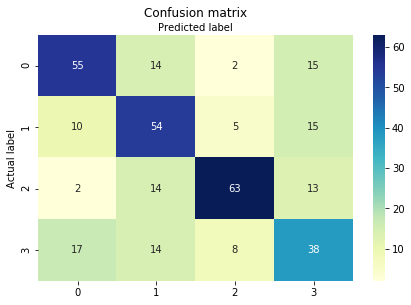

In [445]:
class_names=['Faces', 'Tools', 'Places', 'Body parts'] # Name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [462]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  # Creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    # Creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    # Narking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    # Using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict

print("\nLogistic Regression")

# Assuming your already have a list of actual_class and predicted_class from the logistic regression classifier
lr_roc_auc_multiclass = roc_auc_score_multiclass(y_test, y_pred)
print(lr_roc_auc_multiclass) #0.25 would be worthless classifier, 1 is perfect


Logistic Regression
{'body': 0.7624551888960382, 'tools': 0.6646921780509567, 'faces': 0.7390756302521009, 'places': 0.8120269318781905}


In [ ]:
print("Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
# Evaluate the model and collect the scores - Somatomotor
n_scores_SM = cross_val_score(model, Somatomotor_mean.iloc[:, 3:81], Somatomotor_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Eeport the model performance (M = 0.44, SD = 0.041)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_SM), np.std(n_scores_SM)))

In [ ]:
# Evaluate the model and collect the scores - Cingulo-Oper
n_scores_CO = cross_val_score(model, Cingulo_Oper_mean.iloc[:, 3:81], Cingulo_Oper_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.47, SD = 0.039)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_CO), np.std(n_scores_CO)))

In [ ]:
# Evaluate the model and collect the scores - Language
n_scores_LA = cross_val_score(model, Language_mean.iloc[:, 3:81], Language_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.61, SD = 0.043)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_LA), np.std(n_scores_LA)))

In [ ]:
# Evaluate the model and collect the scores - Default
n_scores_DE = cross_val_score(model, Default_mean.iloc[:, 3:81], Default_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.49, SD = 0.039)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_DE), np.std(n_scores_DE)))

In [ ]:
# Evaluate the model and collect the scores - Frontopariet
n_scores_FP = cross_val_score(model, Frontopariet_mean.iloc[:, 3:81], Frontopariet_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.56, SD = 0.033)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_FP), np.std(n_scores_FP)))

In [ ]:
# Evaluate the model and collect the scores - Auditory
n_scores_AU = cross_val_score(model, Auditory_mean.iloc[:, 3:81], Auditory_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Eeport the model performance (M = 0.50, SD = 0.036)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_AU), np.std(n_scores_AU)))

In [ ]:
# Evaluate the model and collect the scores - Dorsal-atten
n_scores_DA = cross_val_score(model, Dorsal_atten_mean.iloc[:, 3:81], Dorsal_atten_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.45, SD = 0.038)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_DA), np.std(n_scores_DA)))

In [ ]:
# Evaluate the model and collect the scores - Posterior-Mu
n_scores_PM = cross_val_score(model, Posterior_Mu_mean.iloc[:, 3:81], Posterior_Mu_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.46, SD = 0.041)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_PM), np.std(n_scores_PM)))

In [ ]:
# Evaluate the model and collect the scores - Orbito-Affec
n_scores_OA = cross_val_score(model, Orbito_Affec_mean.iloc[:, 3:81], Orbito_Affec_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.37, SD = 0.035)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_OA), np.std(n_scores_OA)))

In [ ]:
# Evaluate the model and collect the scores - Ventral-Mult
n_scores_VM = cross_val_score(model, Ventral_Mult_mean.iloc[:, 3:81], Ventral_Mult_mean.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance (M = 0.49, SD = 0.044)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_VM), np.std(n_scores_VM)))

#### Note: 

Trying out the 2-back task.

In [ ]:
# Return indices to columns (2-back)
X_2back_full_net.reset_index(level=0, inplace=True)
X_2back_full_net.reset_index(level=0, inplace=True)
X_2back_full_net.reset_index(level=0, inplace=True)

In [ ]:
# Visual 2 - 2-back
Visual2_2back = X_2back_full_net.loc[X_2back_full_net['Network'] == 'Visual2']

In [ ]:
# Sanity check
unique(Visual2_2back['Network'])

In [ ]:
# 2-back task

# Evaluate the model and collect the scores - Visual 2
n_scores_V2_2back = cross_val_score(model, Visual2_2back.iloc[:, 3:81], Visual2_2back.iloc[:, 1], scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance 
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores_V2_2back), np.std(n_scores_V2_2back)))

In [ ]:
# See the entire accuracy array
print(n_scores_V2_2back)

#### Note:

Normalization - Jelka

Fourier transform - Alaleh

In [468]:
# Export the data to deal with it in R
X_2back_full.to_csv("/Users/jelkastojanov/Downloads/Two_back_task_NMA.csv")
X_0back_full.to_csv("/Users/jelkastojanov/Downloads/Zero_back_task_NMA.csv")